<a href="https://colab.research.google.com/github/SandeshRangreji/Scientific-Document-Summarization/blob/main/T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install transformers

In [ ]:
import tensorflow as tf
import numpy as np
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer, T5ForConditionalGeneration
import xml.etree.ElementTree as ET
from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
os.mkdir("/content/PGN")
os.mkdir("/content/PGN/data")

In [ ]:
!unzip "/content/drive/MyDrive/Pointer Generator Networks/Data/scisumm.zip" -d "/content/PGN/data/"

In [ ]:
path = "/content/PGN/data/scisummnet_release1.1__20190413/top1000_complete/"
dir_list = os.listdir(path)
print(len(dir_list))

1009


In [ ]:
def get_text(xmlfile):
 sections = []
 intro_flag = False
 conclusion_flag = False
 tree = ET.parse(xmlfile)
 root = tree.getroot()
 for child in root:
  text = ""
  if child.tag != "S":
   if (child.attrib.get("title", child.tag).find("Introduction") != -1) and not intro_flag:
    intro_flag = True
    for grandchild in child:
     text = text + " " + grandchild.text
   if (child.attrib.get("title", child.tag).find("Conclusion") != -1) and not conclusion_flag:
    conclusion_flag = True
    for grandchild in child:
     text = text + " " + grandchild.text
  if text != "":
   sections.append(text)
 return sections, (intro_flag and conclusion_flag)

In [ ]:
a, b = get_text("/content/PGN/data/scisummnet_release1.1__20190413/top1000_complete/A00-1031/Documents_xml/A00-1031.xml") 
print((len(a)))    

2


In [ ]:
def get_articles(dir_list):
  articles = []
  blacklist = []
  articles_index = []
  total = 0
  for file_name in dir_list:
    if file_name not in blacklist:
      xmlfile = "/content/PGN/data/scisummnet_release1.1__20190413/top1000_complete/" + file_name + "/Documents_xml/" + file_name + ".xml"
      try:
        sections, flag = get_text(xmlfile)
        if flag == False:
          total+=1
        else:
          articles.append(sections)
          articles_index.append(xmlfile)
      except:
        blacklist.append(file_name)
  return articles, total, articles_index

In [ ]:
def word_count(sent):
  return len(sent.split(" "))

In [ ]:
articles, total, articles_index = get_articles(dir_list)

In [ ]:
len(articles)

566

In [ ]:
model = TFAutoModelForSeq2SeqLM.from_pretrained('t5-small')
tokenizer = AutoTokenizer.from_pretrained('t5-small')

In [ ]:
def get_reference_summaries(articles_index):
  reference_summaries = []
  for file_name in articles_index:
    start_index = file_name.find("top1000_complete/") + 17
    end_index = file_name.find("/Documents_xml")
    file_name = file_name[start_index:end_index]
    ref_sum_file = "/content/PGN/data/scisummnet_release1.1__20190413/top1000_complete/" + file_name + "/summary/" + file_name + ".gold.txt"
    reference_summary = open(ref_sum_file, "r")
    reference_summaries.append(reference_summary.read())
  return reference_summaries

In [ ]:
reference_summaries = get_reference_summaries(articles_index)

In [ ]:
len(reference_summaries)

566

In [ ]:
def get_tokens(articles, summaries):
  input_tokens_li = []
  output_tokens_li = []
  for i in range(len(articles)):
    article = " ".join(articles[i])
    input_tokens = tokenizer(article, return_tensors='tf', truncation=True, padding='max_length', max_length=512)
    input_tokens_li.append(input_tokens.data)
    output_tokens = tokenizer(summaries[i], return_tensors='tf', truncation=True, padding='max_length', max_length=128)
    output_tokens_li.append(output_tokens.data)
  return input_tokens_li, output_tokens_li

In [ ]:
train_input_tokens, train_output_tokens = get_tokens(articles[:460], reference_summaries[:460])
val_input_tokens, val_output_tokens = get_tokens(articles[461:], reference_summaries[461:])

In [ ]:
def get_average_article_len():
  lens = []
  count = []
  for article in articles:
    lens.append(len(" ".join(article)))
    count.append(1)
  print(sum(lens)/sum(count))

def get_average_summary_len():
  lens = []
  count = []
  for summary in reference_summaries:
    lens.append(len(summary))
    count.append(1)
  print(sum(lens)/sum(count))

In [ ]:
print(len(train_input_tokens), len(train_output_tokens))
print(len(val_input_tokens), len(val_output_tokens))

460 460
105 105


In [ ]:
input_sequences = []
for article in articles:
  input_sequences.append(" ".join(article))

In [ ]:
task_prefix = "summarize: "
max_source_length = 512
max_target_length = 128
dataset_size = 566
validation_split = 400

In [ ]:
initial_learning_rate = 0.00005
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

In [ ]:
def train_step():
  for j in range(validation_split):
    with tf.GradientTape() as tape:
      encoding = tokenizer(task_prefix + input_sequences[j],
                      padding='longest',
                      max_length=max_source_length,
                      truncation=True,
                      return_tensors="tf")
      input_ids, attention_mask = encoding.input_ids, encoding.attention_mask
      target_encoding = tokenizer(reference_summaries[j],
                              padding='longest',
                              max_length=max_target_length,
                              truncation=True,
                              return_tensors="tf")
      labels = target_encoding.input_ids
      labels = tf.convert_to_tensor(labels)
      loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels).loss
      # loss = tf.reduce_mean(loss)
      variables = model.trainable_variables
      gradients = tape.gradient(loss, variables)
      optimizer.apply_gradients(zip(gradients, variables))
  return tf.reduce_mean(loss)

In [ ]:
def val_step():
  model.trainable = False
  for j in range(validation_split, dataset_size):
    with tf.GradientTape() as tape:
      encoding = tokenizer(task_prefix + input_sequences[j],
                      padding='longest',
                      max_length=max_source_length,
                      truncation=True,
                      return_tensors="tf")
      input_ids, attention_mask = encoding.input_ids, encoding.attention_mask
      target_encoding = tokenizer(reference_summaries[j],
                              padding='longest',
                              max_length=max_target_length,
                              truncation=True,
                              return_tensors="tf")
      labels = target_encoding.input_ids
      labels = tf.convert_to_tensor(labels)
      loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels).loss
      # loss = tf.reduce_mean(loss)
      # variables = model.trainable_variables
      # gradients = tape.gradient(loss, variables)
      # optimizer.apply_gradients(zip(gradients, variables))
  model.trainable = True
  return tf.reduce_mean(loss)

In [ ]:
EPOCHS = 5
train_losses = []
validation_losses = []
for i in range(EPOCHS):
  train_loss = train_step()
  validation_loss = val_step()
  train_losses.append(train_loss)
  validation_losses.append(validation_loss)
  print("Epoch " + str(i+1) + ":")
  print("Train Loss: " + str(train_loss))
  print("Validation Loss: " + str(validation_loss))
  print()

Epoch 1:
Train Loss: tf.Tensor(2.549662, shape=(), dtype=float32)
Validation Loss: tf.Tensor(3.494061, shape=(), dtype=float32)

Epoch 2:
Train Loss: tf.Tensor(2.3398397, shape=(), dtype=float32)
Validation Loss: tf.Tensor(3.534045, shape=(), dtype=float32)

Epoch 3:
Train Loss: tf.Tensor(2.118999, shape=(), dtype=float32)
Validation Loss: tf.Tensor(3.6433196, shape=(), dtype=float32)

Epoch 4:
Train Loss: tf.Tensor(1.8659925, shape=(), dtype=float32)
Validation Loss: tf.Tensor(3.8027773, shape=(), dtype=float32)

Epoch 5:
Train Loss: tf.Tensor(1.6110436, shape=(), dtype=float32)
Validation Loss: tf.Tensor(4.043771, shape=(), dtype=float32)



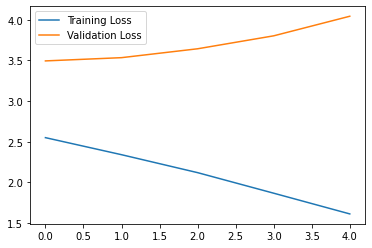

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.legend()

In [ ]:
inference_input_ids = tokenizer(task_prefix + input_sequences[501], padding='max_length',
                      max_length=2048,
                      truncation=True,
                      return_tensors="tf").input_ids
outputs = model.generate(inference_input_ids)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Clustering Polysemic SCF Distributions From Lexical Lexicon Verb Subcate


In [ ]:
c = 0
for i in (inference_input_ids[0]):
  print(c, i)
  c+=1

In [ ]:
reference_summaries[500]

'A Statistical Model For Multilingual Entity Detection And Tracking\nEntity detection and tracking is a relatively new addition to the repertoire of natural language tasks.\nIn this paper, we present a statistical language-independent framework for identifying and tracking named, nominal and pronominal references to entities within unrestricted text documents, and chaining them into clusters corresponding to each logical entity present in the text.\nBoth the mention detection model and the novel entity tracking model can use arbitrary feature types, being able to integrate a wide array of lexical, syntactic and semantic features.\nIn addition, the mention detection model crucially uses feature streams derived from different named entity classifiers.\nThe proposed framework is evaluated with several experiments run in Arabic, Chinese and English texts; a system based on the approach described here and submitted to the latest Automatic Content Extraction (ACE) evaluation achieved top-tie

In [ ]:
len(articles[500][0])

4756

In [ ]:
# tf.Tensor(3.1021361, shape=(), dtype=float32)
# tf.Tensor(2.7721298, shape=(), dtype=float32)
# tf.Tensor(2.454471, shape=(), dtype=float32)
# tf.Tensor(2.0970745, shape=(), dtype=float32)
# tf.Tensor(1.7260841, shape=(), dtype=float32)

In [ ]:
print(tf.reduce_mean(loss))

tf.Tensor(1.6692624, shape=(), dtype=float32)


In [ ]:
# Save the weights
model.save_weights('/content/drive/MyDrive/Pointer Generator Networks/T5/T5_small')

In [ ]:
model.save_weights('/content/PGN')

In [ ]:
print("hi" + train_loss)

TypeError: ignored